In [22]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed

ERROR! Session/line number was not unique in database. History logging moved to new session 2677


In [23]:
def sort(energies,U,H):
    diagonal_elements = np.diag(H)

    # Find the index of the closest diagonal element for each eigenvalue
    closest_indices = np.argmin(abs(energies[:, np.newaxis] - diagonal_elements), axis=1)

    # Sort energies and U according to the indices of closest diagonal elements
    sorted_energies = energies[np.argsort(closest_indices)]
    U = U[:, np.argsort(closest_indices)]
    return sorted_energies,U

In [24]:
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
def T1f(der):
    factor = np.sqrt(2*np.abs(np.log(2*np.pi*1*1e-5)))
    return 1/(factor*10**-6*der)

In [56]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def energy_diff(A,omega,flux):
    #snail parameters
    EJ = 70*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    omegas = snail.omegas
    
    #cavity1 parameters
    omega_c1 = 7*2*np.pi
    g_int1 = 0.15*2*np.pi
    dimc1 = 5
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters
    omega_c2 = 3*2*np.pi
    g_int2 = 0.15*2*np.pi
    dimc2 = 5
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    snailcc = SNAILCC(snail,cavity1,cavity2)
    
    H0,Hc = snailcc.hamiltonian()
    energy,U = np.linalg.eigh(H0)
    U_dag = np.transpose(U.conjugate())
    Hc = U_dag @ Hc @ U
    H0 = U_dag @ H0 @ U
    H0 = H0 - H0[0][0]*np.identity(len(H0))
    indexc11 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    indexc21 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    index12 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy)) - omega_c1 * np.ones(len(energy))))
    indexs1 = np.argmin(np.abs(energy - omegas * np.ones(len(energy))))
    indexsc1 = np.argmin(np.abs(energy - (omegas+omega_c1) * np.ones(len(energy))))
    indexsc2 = np.argmin(np.abs(energy - (omegas+omega_c2) * np.ones(len(energy))))
    indexc12 = np.argmin(np.abs(energy - 2 * omega_c1 * np.ones(len(energy))))
    indexc22 = np.argmin(np.abs(energy - 2 * omega_c2 * np.ones(len(energy))))
    H0 = Qobj(H0)
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = 2*np.pi/omega
#     H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    options = Options(nsteps=1000000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, False, options=options) 
    total_dim = dims*dimc1*dimc2
    basis_states = [basis(total_dim, 0),basis(total_dim, indexc11), basis(total_dim, indexc21),basis(total_dim, index12),
                   basis(total_dim, indexs1),basis(total_dim, indexsc1),basis(total_dim, indexsc2),
                   basis(total_dim, indexc12),basis(total_dim, indexc22)]
    
    
    max_overlap_indices = [0,0,0,0,0,0,0,0,0]
    max_overlaps = [0,0,0,0,0,0,0,0,0]
    for f_index, f_state in enumerate(f_modes):

        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):

            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    energyg = f_energies[max_overlap_indices[0]]/2/np.pi
    omega = 2*np.pi/T

    energyc1p = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energyc1p , omega/2/np.pi)
    energyc1p = energyc1p + k *omega/2/np.pi - energyg
    energyc2p = f_energies[max_overlap_indices[2]]/2/np.pi
    k = find_optimal_k(omega_c2/2/np.pi, energyc2p, omega/2/np.pi)
    energyc2p = energyc2p + k *omega/2/np.pi - energyg
    
    omega12 = f_energies[max_overlap_indices[3]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi+omega_c2/2/np.pi, omega12 , omega/2/np.pi)
    omega12 = omega12 +k *omega/2/np.pi - energyg
    
    diff = omega12 - energyc1p - energyc2p
    
    energys1 = f_energies[max_overlap_indices[4]]/2/np.pi
    k = find_optimal_k(omegas/2/np.pi, energys1, omega/2/np.pi)
    energys1 = energys1 + k*omega/2/np.pi - energyg
    
    energysc1 = f_energies[max_overlap_indices[5]]/2/np.pi
    k = find_optimal_k((omega_c1+omegas)/2/np.pi, energysc1, omega/2/np.pi)
    starkshift1 = energysc1 - energyg + k*omega/2/np.pi - energyc1p - energys1

    energysc2 = f_energies[max_overlap_indices[6]]/2/np.pi
    k = find_optimal_k((omega_c2+omegas)/2/np.pi, energysc2, omega/2/np.pi)
    starkshift2 = energysc2 - energyg + k*omega/2/np.pi - energyc2p - energys1
    
    energyc12 = f_energies[max_overlap_indices[7]]/2/np.pi
    k = find_optimal_k(2*omega_c1/2/np.pi, energyc12, omega/2/np.pi)
    energyc12 = energyc12 +k*omega/2/np.pi
    selfkerr1 = energyc12-energyg - 2*energyc1p
    
    energyc22 = f_energies[max_overlap_indices[8]]/2/np.pi
    k = find_optimal_k(2*omega_c2/2/np.pi, energyc22, omega/2/np.pi)
    energyc22 = energyc22 +k*omega/2/np.pi
    selfkerr2 = energyc22-energyg - 2*energyc2p

    return diff,energyc1p,energyc2p , starkshift1, starkshift2, selfkerr1, selfkerr2,energys1

In [57]:
## import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from autograd.extend import primitive, defvjp
from qutip import *
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def SNAIL_H(phi_ex,beta,N,Ej,Ec):
    phi_ex = 2*np.pi*phi_ex
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp

    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)

    g4 = Ej*phi_zpf**4*c4/4/3/2
    Hs = omega_s * np.matmul(sd,s)
    
    return Hs,-1j*(s-sd),phi_zpf,c2

In [58]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def energy_diff2(A,omega,phi_ex):
    #snail parameters
    EJ = 70*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,phi_ex,N,dims)
    H0,v,phi_zpf,c2 = SNAIL_H(phi_ex,beta,N,EJ,EC)
    Hs,charge_op = snail.spectrum_charge()
    
    
    #cavity1 parameters
    omega_c1 = 7*2*np.pi
    g_int1 = 0.15*2*np.pi
    dimc1 = 5
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters
    omega_c2 = 3*2*np.pi
    g_int2 = 0.15*2*np.pi
    dimc2 = 5
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    
    Hc1, Vc1 = cavity1.hamiltonian()
    Hc2, Vc2 = cavity2.hamiltonian()
    
    Ic1 = np.identity(dimc1)
    Ic2 = np.identity(dimc2)
    Is = np.identity(dims)
    
    Hs = np.kron(np.kron(Hs,Ic1),Ic2)
    Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
    Hc2 = np.kron(np.kron(Is,Ic1),Hc2)
    
    H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    
    H = Hs + Hc1 + Hc2 + H_int1 + H_int2

    energy,U = np.linalg.eigh(H)
    energy,U = sort(energy,U,H)
    energy = energy - energy[0]*np.ones(len(energy))
    
    omegas = snail.omegas
    indexs1 = np.argmin(np.abs(energy - omegas * np.ones(len(energy))))
    energys1 = energy[indexs1]
    indexs2 = np.argmin(np.abs(energy - (2*omegas ) * np.ones(len(energy))))
    anh = energy[indexs2] - 2*energys1
    
    indexc11 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    energyc11 = energy[indexc11]
    indexc12 = np.argmin(np.abs(energy - 2 * omega_c1 * np.ones(len(energy))))
    energyc12 = energy[indexc12]
    indexsc11 = np.argmin(np.abs(energy - (omegas+omega_c1) * np.ones(len(energy))))
    energysc11 = energy[indexsc11]
    indexsc12 = np.argmin(np.abs(energy - (omegas+2*omega_c1) * np.ones(len(energy))))
    energysc12 = energy[indexsc12]
    
    starkshift11 = energysc11  - energyc11 - energys1
    selfkerr1 = energyc12 - 2*energyc11
    starkshift12 = energysc12  - 2*energyc11 - energys1 - 2*starkshift11 - 2*selfkerr1
    
    indexc21 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    energyc21 = energy[indexc21]
    indexc22 = np.argmin(np.abs(energy - 2 * omega_c2 * np.ones(len(energy))))
    energyc22 = energy[indexc22]
    indexsc21 = np.argmin(np.abs(energy - (omegas+omega_c2) * np.ones(len(energy))))
    energysc21 = energy[indexsc21]
    indexsc22 = np.argmin(np.abs(energy - (omegas+2*omega_c2) * np.ones(len(energy))))
    energysc22 = energy[indexsc22]
    
    starkshift21 = energysc21  - energyc21 - energys1
    selfkerr2 = energyc22 - 2*energyc21
    starkshift22 = energysc22  - 2*energyc21 - energys1 - 2*starkshift21 - 2*selfkerr2
    
    index12 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy)) - omega_c1 * np.ones(len(energy))))
    energy12 = energy[index12]
    index121 = np.argmin(np.abs(energy - (omega_c2+omega_c1+omegas) * np.ones(len(energy))))
    energy121 = energy[index121]
    crosskerr = energy12 - energyc11 - energyc21
    scrosskerr = energy121 - energyc11 - energyc21 - energys1 - starkshift11 - starkshift21
    return energys1,anh,energyc11,selfkerr1, starkshift11,starkshift12,energyc21,selfkerr2, starkshift21,starkshift22,crosskerr,scrosskerr

In [59]:
def app(A,omega,phi_ex):
    EJ = 70*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 100
    flux = 0.48
    N = 3
    dims = 10
    H0,v,phi_zpf,c2 = SNAIL_H(phi_ex,beta,N,EJ,EC)
    dimc = 4
    s = annihilation(dims)
    sd = creation(dims)
    c = annihilation(dimc)
    cd = creation(dimc)
    Ic = np.identity(dimc)
    Is = np.identity(dims)
    energys1,anh,energyc11,selfkerr1, starkshift11,starkshift12,energyc21,selfkerr2, starkshift21,starkshift22,crosskerr,scrosskerr=energy_diff2(A,omega,phi_ex)
    delta = energys1-omega 
    
    Hs = delta*sd@s +anh/2*sd@sd@s@s + A/2*(s+sd)/2/phi_zpf

    energies,U=np.linalg.eig(Hs)
    energies,U = sort(energies,U,Hs)
    Ud = U.transpose().conjugate()
    Hs = np.kron(np.kron(np.diag(energies),Ic),Ic)
    
    Hc1 = energyc11*cd@c + selfkerr1/2*cd@cd@c@c
    Hc1 = np.kron(np.kron(Is,Hc1),Ic)
    Hc2 = energyc21*cd@c + selfkerr2/2*cd@cd@c@c
    Hc2 = np.kron(np.kron(Is,Ic),Hc2)
    H_int1 = starkshift11 * np.kron(Ud@sd@s@U,cd@c)+starkshift12/2* np.kron(Ud@sd@s@U,cd@cd@c@c)
    H_int1 = np.kron(H_int1,Ic)
    H_int2 = starkshift21 * np.kron(np.kron(Ud@sd@s@U,Ic),cd@c)+starkshift22/2* np.kron(np.kron(Ud@sd@s@U,Ic),cd@cd@c@c)
    H_int3 = crosskerr*np.kron(np.kron(Is,cd@c),cd@c) + scrosskerr*np.kron(np.kron(Ud@sd@s@U,cd@c),cd@c)
    
    H = Hs + Hc1 + Hc2 +H_int1+H_int2 + H_int3
    energy,U = np.linalg.eigh(H)

    # Compute the overlaps (absolute values of the first elements of the columns of U)
    overlaps = np.abs(U[0, :])**2

    # Find the index of the maximum overlap
    max_overlap_index = np.argmax(overlaps)
    energy = energy - energy[max_overlap_index]*np.ones(len(energy))
    overlaps = np.abs(U[dimc**2, :])**2

    # Find the index of the maximum overlap
    indexs1 = np.argmax(overlaps)
    energys1 = energy[indexs1]
    index12 = np.argmin(np.abs(energy - energyc11  * np.ones(len(energy)) - energyc21  * np.ones(len(energy))))
    
    indexc11 = np.argmin(np.abs(energy - energyc11 * np.ones(len(energy))))
    indexc12 = np.argmin(np.abs(energy - 2 * energyc11 * np.ones(len(energy))))
    indexsc11 = np.argmin(np.abs(energy - (delta+energyc11) * np.ones(len(energy))))
    energysc11 = energy[indexsc11]
    energyc11 = energy[indexc11]
    energyc12 = energy[indexc12]
    starkshift11 = energysc11  - energyc11 - energys1
    selfkerr1 = energyc12 - 2*energyc11
    indexc21 = np.argmin(np.abs(energy - energyc21 * np.ones(len(energy)))) 
    indexc22 = np.argmin(np.abs(energy - 2 * energyc21 * np.ones(len(energy))))
    indexsc21 = np.argmin(np.abs(energy - (delta+energyc21) * np.ones(len(energy))))
    energysc21 = energy[indexsc21]
    energyc21 = energy[indexc21]
    energyc22 = energy[indexc22]
    
    starkshift21 = energysc21  - energyc21 - energys1
    selfkerr2 = energyc22 - 2*energyc21
    
    
    
    energy12 = energy[index12]
    crosskerr = energy12 - energyc11 - energyc21
    return crosskerr/2/np.pi, energyc11/2/np.pi, energyc21/2/np.pi,  starkshift11/2/np.pi, starkshift21/2/np.pi, selfkerr1/2/np.pi, selfkerr2/2/np.pi

In [60]:
(app)(A, omega, flux)

(7.590228415012441e-08,
 7.0041550683405704,
 2.9926768102373167,
 0.0001565152289003022,
 9.791687868778119e-05,
 1.95866009677537e-07,
 1.0991365957089112e-07)

In [61]:
omega = 4.83 * 2 * np.pi
A = 0.005 * 2 * np.pi
flux = 0.435
(energy_diff2)(A, omega, flux)

(30.45737900469581,
 0.17158532409406746,
 44.008369965195484,
 1.8696215846603081e-06,
 0.001040910432109854,
 -1.230750413583337e-06,
 18.80352146093559,
 9.572165424742707e-07,
 0.0006513401899290727,
 -9.117581925011109e-07,
 7.824144709900338e-07,
 2.2148579574832183e-06)

In [79]:
from joblib import Parallel, delayed
omega = 4.83 * 2 * np.pi
A = 0.005 * 2 * np.pi
fluxs = np.linspace(0.42, 0.44, 100)
# Using joblib to parallelize the loo
cross_kerrs = Parallel(n_jobs=-1)(delayed(app)(A, omega, flux) for flux in fluxs)


In [80]:
cross_kerrs = np.array(cross_kerrs)

In [ ]:
cross_kerrs1 = Parallel(n_jobs=-1)(delayed(energy_diff)(A, omega, flux) for flux in fluxs)

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


In [81]:
cross_kerrs1 = np.array(cross_kerrs1)

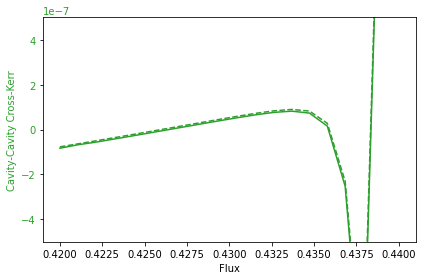

In [66]:
# Plotting the new data in a similar style with a different y-axis

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Flux')
ax1.set_ylabel('Cavity-Cavity Cross-Kerr', color=color)
ax1.plot(fluxs, cross_kerrs1[:, 0], color=color)
ax1.plot(fluxs, cross_kerrs[:, 0],'--',color=color, )
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-5e-7,5e-7)
fig.tight_layout()
plt.show()

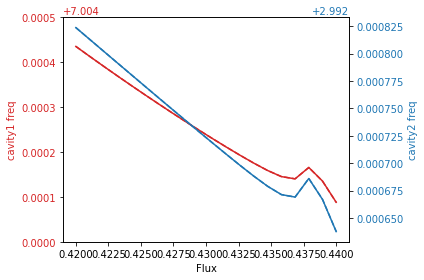

In [67]:
# Plotting with two different y-axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Flux')
ax1.set_ylabel('cavity1 freq', color=color)
ax1.plot(fluxs, cross_kerrs1[:, 1], color=color)
ax1.plot(fluxs, cross_kerrs[:, 1],'--',color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(7.004,7.0045)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cavity2 freq', color=color)  # we already handled the x-label with ax1
ax2.plot(fluxs, cross_kerrs1[:, 2], color=color)
ax2.plot(fluxs, cross_kerrs[:, 2], '--',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()

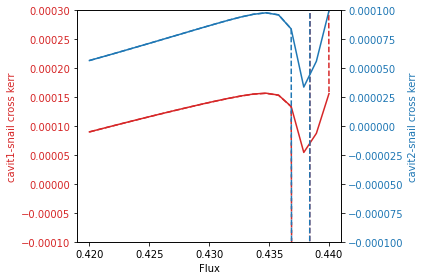

In [78]:
# Plotting with two different y-axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Flux')
ax1.set_ylabel('cavit1-snail cross kerr', color=color)
ax1.plot(fluxs, cross_kerrs1[:, 3], color=color)
ax1.plot(fluxs, cross_kerrs[:, 3],'--', color=color)
ax1.set_ylim(-1e-4,3e-4)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cavit2-snail cross kerr', color=color)  # we already handled the x-label with ax1
ax2.plot(fluxs, cross_kerrs1[:, 4], color=color)
ax2.plot(fluxs, cross_kerrs[:, 4],'--', color=color)
ax2.set_ylim(-1e-4,1e-4)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()

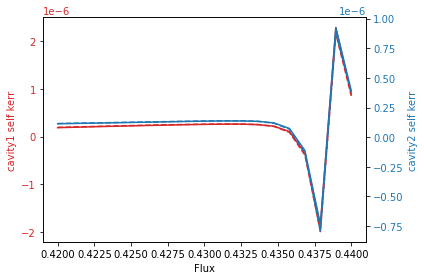

In [69]:
# Plotting with two different y-axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Flux')
ax1.set_ylabel('cavity1 self kerr', color=color)
ax1.plot(fluxs, cross_kerrs[:, 5],'--', color=color)
ax1.plot(fluxs, cross_kerrs1[:, 5], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cavity2 self kerr', color=color)  # we already handled the x-label with ax1
ax2.plot(fluxs, cross_kerrs[:, 6],'--', color=color)
ax2.plot(fluxs, cross_kerrs1[:, 6], color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax1.set_ylim(-1e-6,1e-7)
# ax2.set_ylim(-1e-7,1e-7)
fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()